In [7]:
import pandas as pd
import shap
import numpy as np
shap.initjs()

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [9]:
import catboost
from catboost import *
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [139]:
file_path = './data/diabetes.csv'
df = pd.read_csv(file_path)


#X = df[df['BMI'] != 0].drop(columns=['Outcome']) 
#y = df[df['BMI'] != 0]['Outcome']  
X = df.drop(columns=['Outcome'])
y = df['Outcome']
filtered_indices = X[(X['BMI'] <= 25.9) & (X['Glucose'] >= 125) & (147 >= X['Glucose'])].index
print(filtered_indices)

Index([  9,  28,  63,  93,  94, 102, 140, 242, 307, 340, 384, 392, 401, 433,
       459, 478, 511, 519, 571, 626, 684, 686, 688],
      dtype='int64')


In [140]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [141]:
cat_features_indices = [1]
cat_features_indices = []
model = CatBoostClassifier(iterations=500, learning_rate=0.1, random_seed=12, cat_features=cat_features_indices, depth=6, l2_leaf_reg=3)
model.fit(X_train, y_train, verbose=False, plot=False)

# XGboostとlightGBMを使って学習する場合
# model = XGBClassifier()
# model.fit(X_train, y_train)
#model = LGBMClassifier(iterations=500, learning_rate=0.1, random_seed=12, cat_features=cat_features_indices, depth=6, l2_leaf_reg=3)
#model.fit(X_train, y_train)

In [134]:
# 精度の高いモデル https://www.kaggle.com/code/ramzanzdemir/diabetes-classification-with-lightgbm-89-acc#Create-Models
'''
from sklearn.model_selection import cross_validate, GridSearchCV
file_path = './data/diabetes.csv'
df = pd.read_csv(file_path)


df['Insulin'] = df['Insulin'].where((df['Insulin'] > 0)).fillna(df.groupby('Outcome')["Insulin"].transform("mean"))
df['SkinThickness'] = df['SkinThickness'].where((df['SkinThickness'] > 0)).fillna(df.groupby('Outcome')["SkinThickness"].transform("mean"))


y = df["Outcome"]
X = df.drop('Outcome',axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
cat_features_indices = []
model = CatBoostClassifier(iterations=500, learning_rate=0.1, random_seed=12, cat_features=cat_features_indices, depth=6, l2_leaf_reg=3)
model.fit(X_train, y_train, verbose=False, plot=False)
'''

In [142]:
y_pred = model.predict(X_test)

# 予測精度の評価
accuracy = model.score(X_test, y_test)
print('accuracy:', accuracy)

accuracy: 0.7207792207792207


In [173]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# visualize the first prediction's explanation
f = shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:], link="logit", show=False)
shap.save_html("ex/diabetes1.htm", f)
f = shap.force_plot(explainer.expected_value, shap_values[1,:], X.iloc[1,:], link="logit")
shap.save_html("ex/diabetes2.htm", f)
f = shap.force_plot(explainer.expected_value, shap_values[92,:], X.iloc[92,:], link="logit")
shap.save_html("ex/diabetes3.htm", f)
f = shap.force_plot(explainer.expected_value, shap_values[28,:], X.iloc[28,:], link="logit")
shap.save_html("ex/diabetes4.htm", f)

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


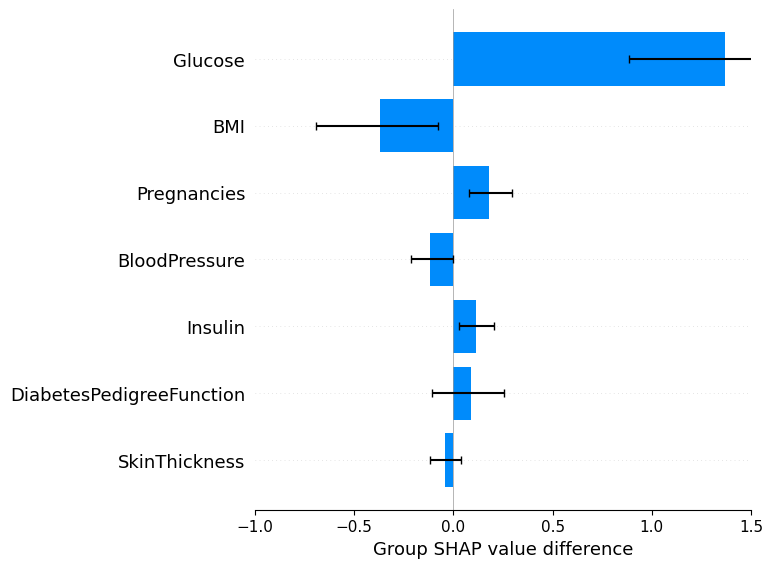

In [176]:
# 1次元では根拠をうまく説明できない変数を検出したい

In [144]:
print(y[0])
print(y[1])
print(y[92])
print(y[28])

1
0
0
0


In [146]:
# shap値への影響が大きい特徴量を表示
n=2
mean_absolute_shap_values = np.abs(shap_values).mean(axis=0)
top_n_features_indices = np.argsort(mean_absolute_shap_values)[::-1][:n]
top_n_feature_names = X.columns[top_n_features_indices]
print(top_n_feature_names)

Index(['Glucose', 'BMI'], dtype='object')


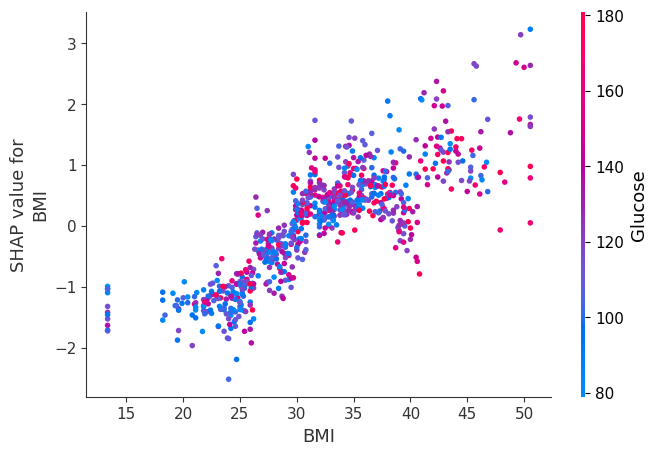

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


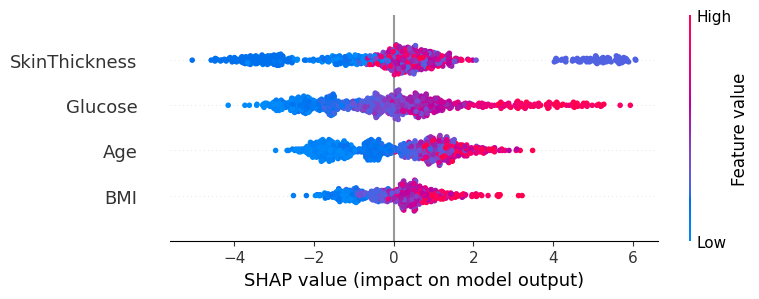

In [65]:
shap.dependence_plot("BMI", shap_values, X, interaction_index="Glucose") #よく分からん
shap.summary_plot(shap_values, X, max_display=4)
# shap_valuesのうち３つの特徴量に対するsummary_plotを表示


予測

In [84]:
X,y = shap.datasets.california(n_points=1000)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [85]:
model = CatBoostRegressor(iterations=300, learning_rate=0.1, random_seed=123)
model.fit(X_train, y_train, verbose=False, plot=False)

In [86]:
y_pred = model.predict(X_test)

# 予測精度の評価
accuracy = model.score(X_test, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.8016468620582599


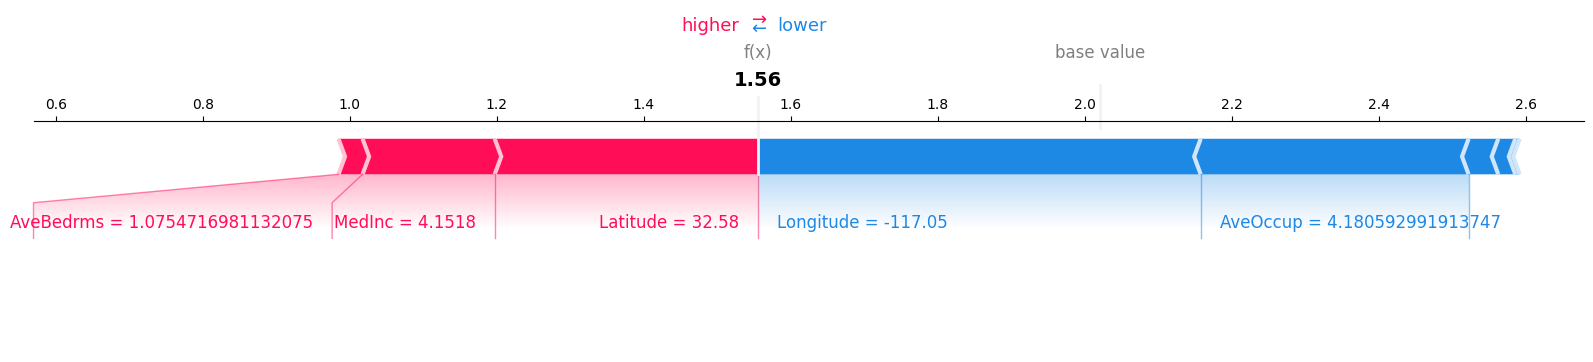

In [87]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:], matplotlib=True)

In [91]:
# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values, X)

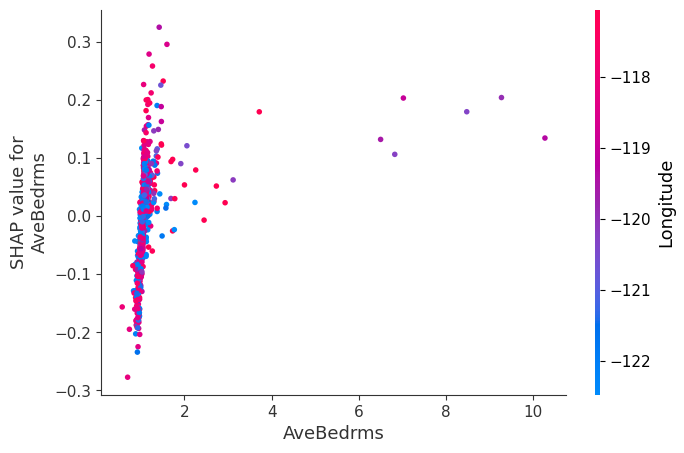

In [92]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("AveBedrms", shap_values, X)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


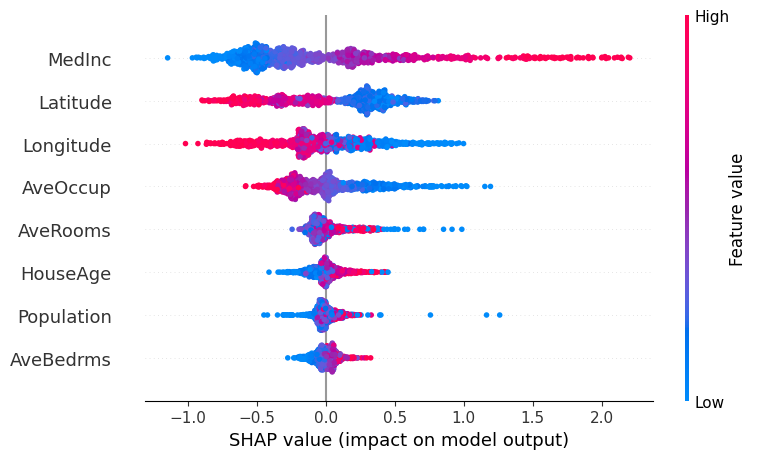

In [93]:
shap.summary_plot(shap_values, X)

分類

In [94]:
from catboost.datasets import *
train_df, test_df = catboost.datasets.amazon()
y = train_df.ACTION
X = train_df.drop('ACTION', axis=1)
cat_features = list(range(0, X.shape[1]))

In [95]:
model = CatBoostClassifier(iterations=300, learning_rate=0.1, random_seed=12)
model.fit(X, y, cat_features=cat_features, verbose=False, plot=False)

In [96]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(Pool(X, y, cat_features=cat_features))

In [97]:
test_objects = [X.iloc[0:1], X.iloc[91:92]]

for obj in test_objects:
    print('Probability of class 1 = {:.4f}'.format(model.predict_proba(obj)[0][1]))
    print('Formula raw prediction = {:.4f}'.format(model.predict(obj, prediction_type='RawFormulaVal')[0]))
    print('\n')

Probability of class 1 = 0.9970
Formula raw prediction = 5.8198


Probability of class 1 = 0.0242
Formula raw prediction = -3.6955




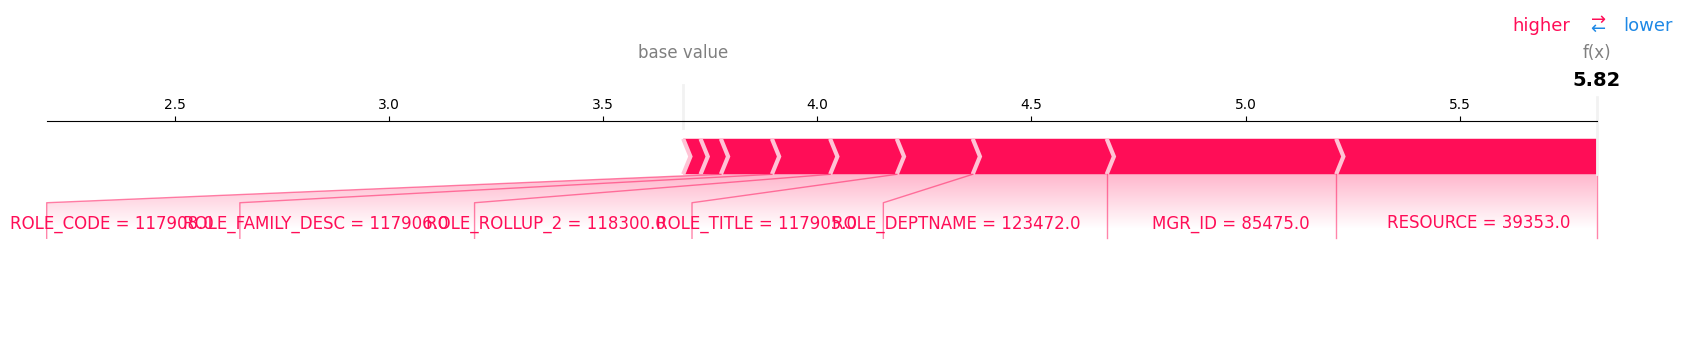

In [98]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:], matplotlib=True)

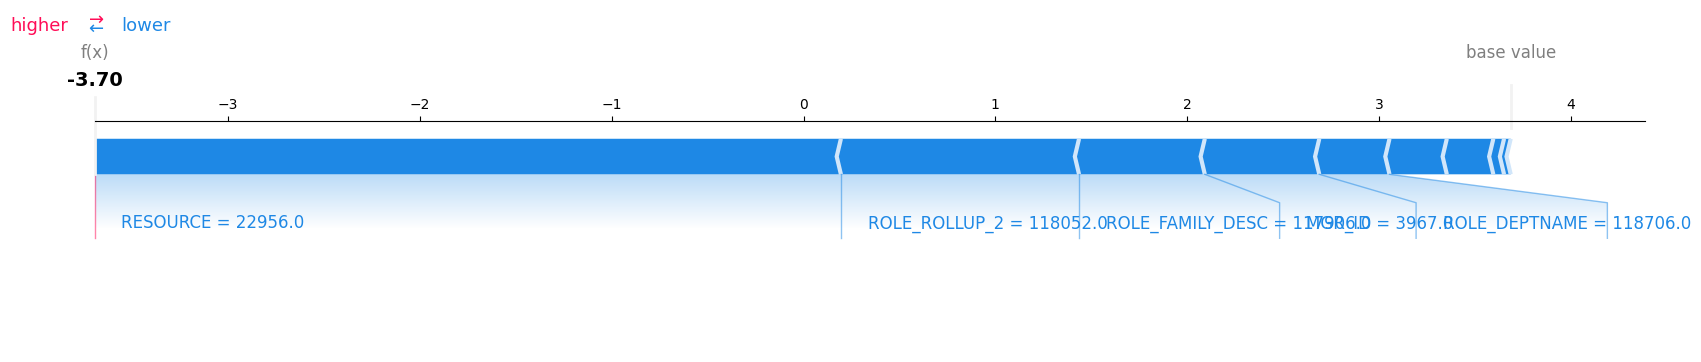

In [99]:
shap.force_plot(explainer.expected_value, shap_values[91,:], X.iloc[91,:], matplotlib=True)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


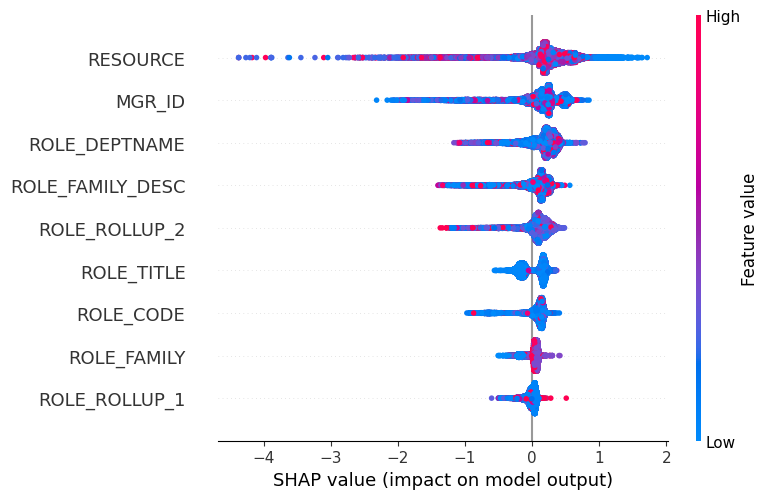

In [100]:
shap.summary_plot(shap_values, X)

多値分類

In [101]:
model = CatBoostClassifier(loss_function = 'MultiClass', iterations=300, learning_rate=0.1, random_seed=123)
model.fit(X, y, cat_features=cat_features, verbose=False, plot=False)

In [102]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(Pool(X, y, cat_features=cat_features))

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


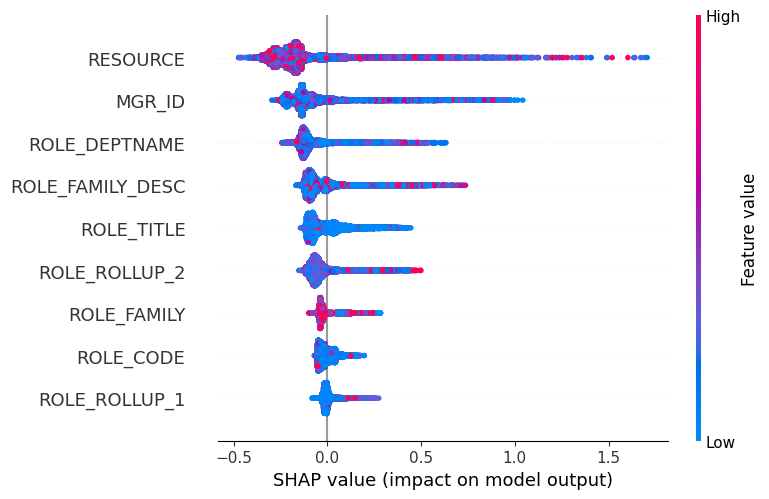

In [103]:
shap.summary_plot(shap_values[0], X)


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


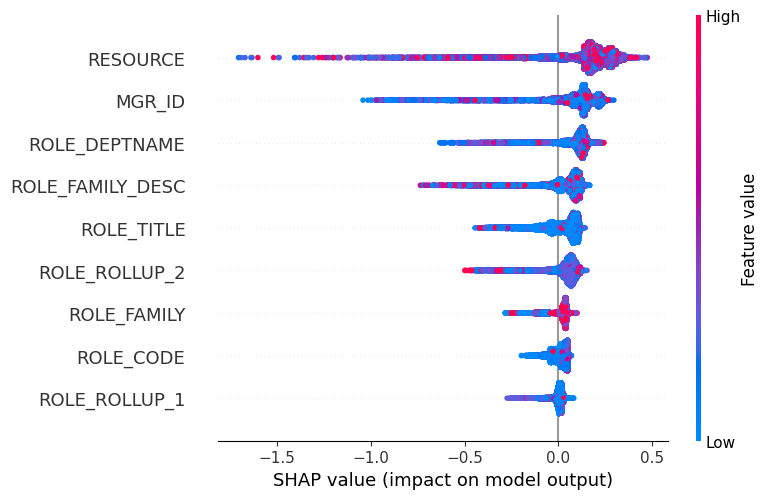

In [104]:
shap.summary_plot(shap_values[1], X)
